::: {.callout-note}
Note: data from the Coursera course [Applied Machine Learning in Python](https://www.coursera.org/learn/python-machine-learning?specialization=data-science-python)
:::

## About the prediction problem

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners.

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. Here the task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

Two data files are provided: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

**File descriptions**

- train.csv - the training set
- test.csv - the test set

**Data fields**

train.csv & test.csv:

- title_word_count - the number of words in the title of the video.
    
- document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.

- freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.

- easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.

- fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.

- speaker_speed - The average speaking rate in words per minute of the presenter in the video.

- silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
- engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.

More details on the original VLE dataset and others related to video engagement [here](https://github.com/sahanbull/VLE-Dataset).



In [181]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

np.random.seed(0)

## Load dataset

In [5]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train['engagement'] = df_train['engagement'].astype(int)

## Exploratoy Data Analysis

### Feature Distribution

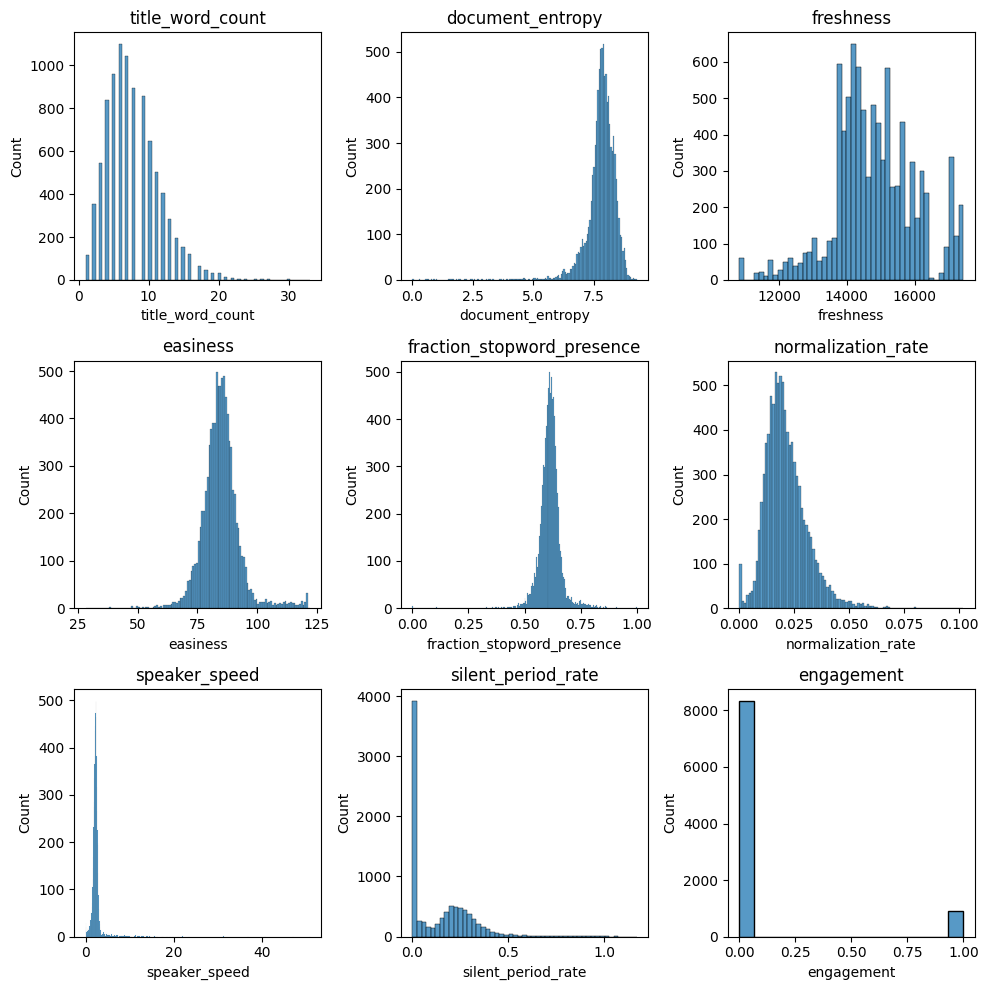

In [7]:
import seaborn as sns
fig, subaxes = plt.subplots(3, 3, figsize=(10, 10))
i = 1
for row in subaxes:
    for this_axis in row:
        sns.histplot(df_train.iloc[:, i], ax=this_axis)
        this_axis.set_title('{}'.format(df_train.columns[i]))
        i += 1
plt.tight_layout()
plt.show()

### Feature Correlation

From the heatmap we can observe that there's not large correlations between the variables, except for **easiness** and **normalization_rate**.

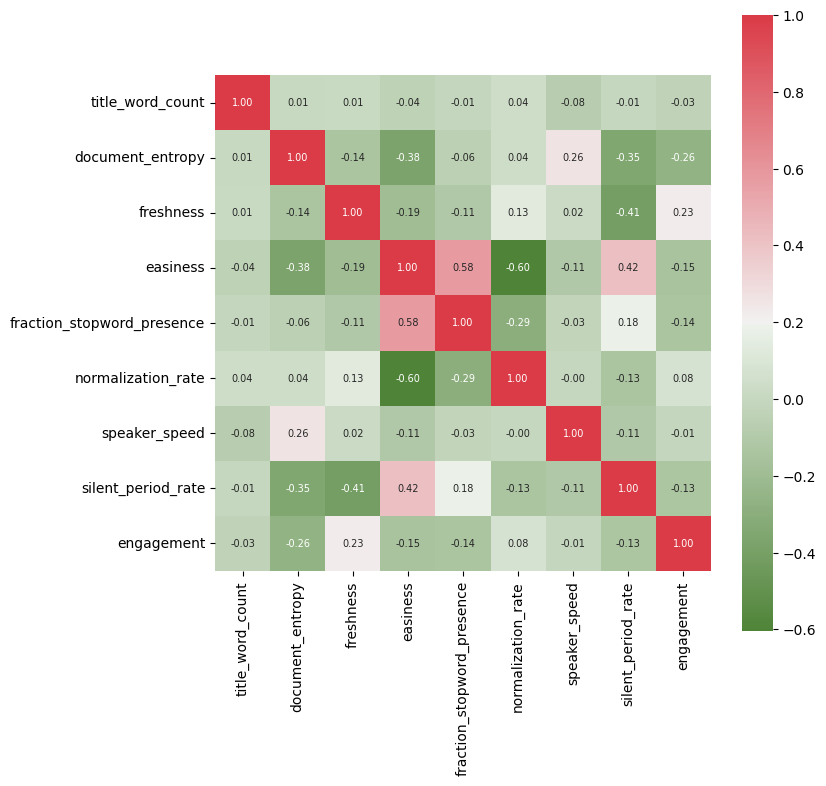

In [9]:
df_corr = df_train.iloc[:,1:].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 7},
           xticklabels= df_corr.columns, 
           yticklabels= df_corr.columns,
           cmap=sns.diverging_palette(120, 10, as_cmap=True))
plt.show()

### Feature Selection

Here the most important features are **document_entropy**, **freshness** and **easiness**.

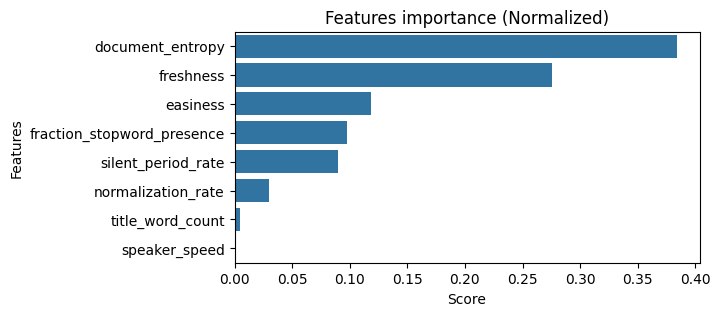

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1] ## engagement

this_k = 8
selector = SelectKBest(f_classif, k='all')
selector.fit(X, y)

# get the score for each feature
scores = selector.scores_

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
total = feature_scores['Score'].sum()
feature_scores['Score'] = feature_scores['Score']/total
feature_scores.sort_values('Score', ascending=False, inplace=True)

plt.figure(figsize=(6,3))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Features importance (Normalized)')
# plt.xticks(rotation=20, ha='right')
plt.show()

### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

top_features = ['document_entropy', 'freshness', 'easiness']
X_train, y_train = df_train[top_features], df_train['engagement'].astype(int)
X_test = df_test[top_features]
    
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.8750181867018478


### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rfc = GradientBoostingClassifier(random_state=0)

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.8646361089042813


### Gaussian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8271618585290608
{'var_smoothing': 1e-10}


### Explore model performance

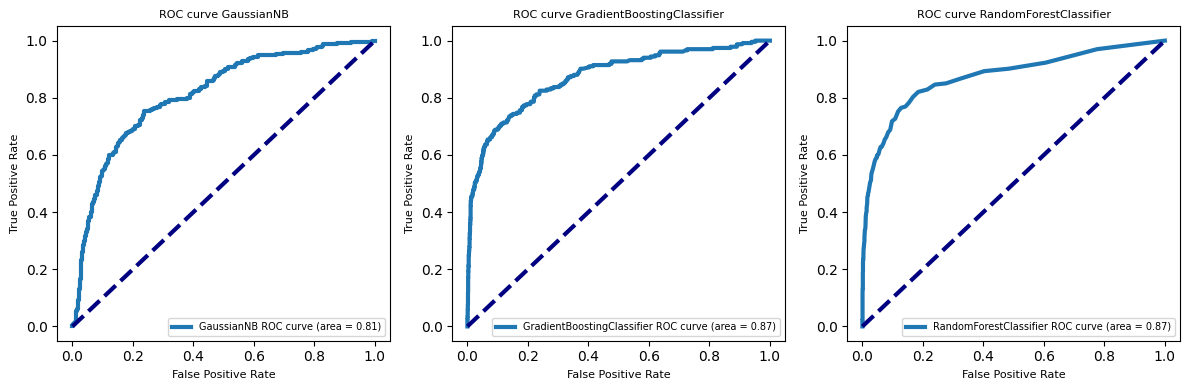

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clfs = ['GaussianNB', 'GradientBoostingClassifier', 'RandomForestClassifier']

fig, subaxes = plt.subplots(1, 3, figsize=(12, 4))
for clf, this_axis in zip(clfs, subaxes):
    nbclf = eval(clf)().fit(X_train, y_train)
    y_probabilities = nbclf.predict_proba(X_test)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probabilities[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    this_axis.plot(fpr_lr, tpr_lr, lw=3, label='{}'.format(clf) + ' ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    this_axis.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    this_axis.legend(loc='lower right', fontsize=7)
    this_axis.set_xlabel('False Positive Rate', fontsize=8)
    this_axis.set_ylabel('True Positive Rate', fontsize=8)
    this_axis.set_title('ROC curve {}'.format(clf), fontsize=8)
plt.tight_layout()
plt.show()

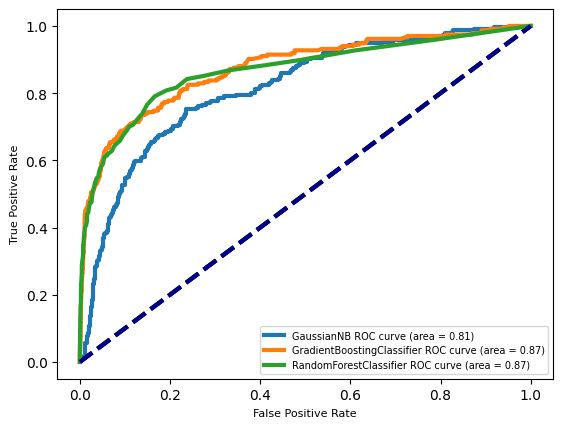

In [15]:
for clf in clfs:
    nbclf = eval(clf)().fit(X_train, y_train)
    y_probabilities = nbclf.predict_proba(X_test)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probabilities[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=3, label='{}'.format(clf) + ' ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.legend(loc='lower right', fontsize=7)
    plt.xlabel('False Positive Rate', fontsize=8)
    plt.ylabel('True Positive Rate', fontsize=8)

## Peformance evaluation on the best models

Since labels for the 2309 test set videos are not provided, I evalaute performance of models on the validation set.

In [183]:
top_features = ['document_entropy', 'freshness', 'easiness']

X = df_train[top_features]
y = df_train['engagement'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

## results from grid search
#  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
clf_rf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=1, 
                               min_samples_split=5, n_estimators=100, n_jobs=-1, 
                               random_state=0)

## results from grid search
# {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
clf_gb = GradientBoostingClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2, 
                                   min_samples_split=5, n_estimators=200, random_state=0)

clf_rf.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)

y_pred = clf_rf.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
print(f"Random Forest AUROC: {roc_auc:.3f}")

clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
print(f"Gradient Boost AUROC: {roc_auc:.3f}")

Random Forest AUROC: 0.854
Gradient Boost AUROC: 0.837


Cross validatated performance ...

In [63]:
metrics = ['roc_auc', 'average_precision', 'balanced_accuracy']
perfname = ['AUROC', 'AUPRC', 'Balanced Accuracy']

clfs = [clf_rf, clf_gb]
clfsname = ['Random Forest', 'Gradient Boost']

for clf, clfname in zip(clfs, clfsname):
  for perf, name in zip(metrics, perfname):
    scores = cross_val_score(clf, X, y, cv=5, scoring=perf)
    print(f"{clfname} - Averaged {name}: {scores.mean():.3f}")

Random Forest - Averaged AUROC: 0.875
Random Forest - Averaged AUPRC: 0.610
Random Forest - Averaged Balanced Accuracy: 0.699
Gradient Boost - Averaged AUROC: 0.849
Gradient Boost - Averaged AUPRC: 0.562
Gradient Boost - Averaged Balanced Accuracy: 0.712


## Prediction on the 2309 test set videos

In [180]:
top_features = ['document_entropy', 'freshness', 'easiness']

X_train, y_train = df_train[top_features], df_train.iloc[:,-1].astype(int)
X_test = df_test[top_features]

## results from grid search
#  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
clf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=1, 
                              min_samples_split=5, n_estimators=100, n_jobs=-1, 
                              random_state=0)

## results from grid search
# {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
# clf = GradientBoostingClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2, 
#                                  min_samples_split=5, n_estimators=200, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)

indexes = df_test['id'].values
probabilities = y_pred[:,1]

pred = pd.Series(probabilities, index=indexes)
pred

9240     0.010444
9241     0.031429
9242     0.066196
9243     0.751450
9244     0.012729
           ...   
11544    0.018296
11545    0.023312
11546    0.015856
11547    0.863286
11548    0.053050
Length: 2309, dtype: float64